## Approach

- load Pandas DataFrame containing electricity data
- split the data in train, test and validation sets (+ normalise independent variables if required)
- fit model parameters using GridSearchCV [scikit-learn](http://scikit-learn.org/stable/)
- evaluate estimator performance by means of 5 fold 'shuffled' nested cross-validation
- predict cross validated estimates of y for each data point and plot on scatter diagram vs true y
- find the best model and fit to validation set to find electricity demand

## Packages required

- [Python 3.8](https://www.python.org/downloads/)
- [Matplotlib](https://matplotlib.org/)
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://docs.scipy.org/doc/)
- [scikit-learn](http://scikit-learn.org/stable/)

## Implement 

#### Install packages

In [5]:
!pip install scikit-learn
!pip install xgboost

In [6]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import xgboost as xgb

#### Preprocessing

- Read the dataset

In [8]:
file = pd.read_csv('Data.csv')
file = pd.DataFrame(file)
file

,period,temperature,hours before sunrise,hours before sunset,demand
0,1,8.4,6.016667,17.633333,496.0
1,2,8.1,5.516667,17.133333,535.0
2,3,7.8,5.016667,16.633333,511.0
3,4,7.5,4.516667,16.133333,496.0
4,5,7.3,4.016667,15.633333,490.0
...,...,...,...,...,...
52555,52556,12.4,-15.516667,-3.800000,NaN
52556,52557,12.3,-16.016667,-4.300000,NaN
52557,52558,12.2,-16.516667,-4.800000,NaN
52558,52559,11.9,-17.016667,-5.300000,NaN


- Split to train, test and validation datasets

In [9]:
df = file[file.demand.notnull()]
df

,period,temperature,hours before sunrise,hours before sunset,demand
0,1,8.4,6.016667,17.633333,496.0
1,2,8.1,5.516667,17.133333,535.0
2,3,7.8,5.016667,16.633333,511.0
3,4,7.5,4.516667,16.133333,496.0
4,5,7.3,4.016667,15.633333,490.0
...,...,...,...,...,...
48235,48236,13.2,-17.666667,-1.183333,998.0
48236,48237,12.1,-18.166667,-1.683333,867.0
48237,48238,12.1,-18.666667,-2.183333,730.0
48238,48239,12.1,-19.166667,-2.683333,608.0


In [10]:
y = df.demand
y

0        496.0
1        535.0
2        511.0
3        496.0
4        490.0
         ...  
48235    998.0
48236    867.0
48237    730.0
48238    608.0
48239    517.0
Name: demand, Length: 48240, dtype: float64

- Drop period and demand

In [11]:
X = df.drop('period', axis=1).drop('demand', axis = 1)
X

,temperature,hours before sunrise,hours before sunset
0,8.4,6.016667,17.633333
1,8.1,5.516667,17.133333
2,7.8,5.016667,16.633333
3,7.5,4.516667,16.133333
4,7.3,4.016667,15.633333
...,...,...,...
48235,13.2,-17.666667,-1.183333
48236,12.1,-18.166667,-1.683333
48237,12.1,-18.666667,-2.183333
48238,12.1,-19.166667,-2.683333


- Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

- Validation set

In [13]:
df_vali = file[file.demand.isnull()]

In [14]:
vali = df_vali.drop('period', axis=1).drop('demand', axis = 1)
vali

,temperature,hours before sunrise,hours before sunset
48240,11.9,3.833333,20.316667
48241,12.0,3.333333,19.816667
48242,12.1,2.833333,19.316667
48243,12.0,2.333333,18.816667
48244,11.9,1.833333,18.316667
...,...,...,...
52555,12.4,-15.516667,-3.800000
52556,12.3,-16.016667,-4.300000
52557,12.2,-16.516667,-4.800000
52558,11.9,-17.016667,-5.300000


#### Defind the pipeline models

- defind pipeline
- cross validation
- show model coefficients or feature importances
- plot predicted demand vs actual demand
- fit the validation set

In [20]:
def model(pipeline, parameters, X_train, y_train, X, y):

    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)
    
    grid_obj.predict(vali)
    
    
    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
#     results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)
    results_vali = grid_obj.predict(vali)
    

    print("##### Results")
#     print(results_sorted)
    print(results)
    print(results_vali)

    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)

    
    '''Cross Validation'''
    # Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,
                    shuffle=True,
                    random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.values.ravel(),
                                cv=shuffle,
                                scoring='r2')
    print("##### CV Results")
    print("mean_score", cv_scores.mean())

    
    '''Show model coefficients or feature importances''' 
    # Feature importance refers to how useful a feature is at predicting a target variable. 
    # A coefficient refers to a number or quantity placed with a variable.

    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")

    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

        
    '''Predict y vs y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)

    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True demand")
    plt.ylabel("Predicted demand")
    plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
             xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    plt.annotate(grid_obj.best_params_, size=9,
                 xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('predicted demand vs actual demand')
    plt.show()

    
    '''Fit the validation set'''
    
    # convert array to serial 
    vali_series = pd.Series(results_vali)

    df_vali.iloc[:,4] = vali_series.values
    print(df_vali)

#### Pipeline and Parameters

- Linear Regression

In [21]:
pipe_ols = Pipeline([('scl', StandardScaler()),
                     ('clf', LinearRegression())])

param_ols = {}

- XGBoost

In [22]:
# - XGBoost

pipe_xgb = Pipeline([('scl', StandardScaler()),
                     ('clf', xgb.XGBRegressor())])

param_xgb = {'clf__max_depth':[5],
             'clf__min_child_weight':[6],
             'clf__gamma':[0.01],
             'clf__subsample':[0.7],
             'clf__colsample_bytree':[1]}


- KNN

In [23]:
pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

- Lasso

In [24]:
pipe_lasso = Pipeline([('scl', StandardScaler()),
                       ('clf', Lasso(max_iter=1500))])

param_lasso = {'clf__alpha': [0.01, 0.1, 1, 10]}

- Ridge

In [25]:
pipe_ridge = Pipeline([('scl', StandardScaler()),
                       ('clf', Ridge())])

param_ridge = {'clf__alpha': [0.01, 0.1, 1, 10]}

- Polynomial Regression

In [26]:
pipe_poly = Pipeline([('scl', StandardScaler()),
                      ('polynomial', PolynomialFeatures()),
                      ('clf', LinearRegression())])

param_poly = {'polynomial__degree': [2, 4, 6]}

- Decision Tree Regression

In [28]:
pipe_tree = Pipeline([('scl', StandardScaler()),
                      ('clf', DecisionTreeRegressor())])

param_tree = {'clf__max_depth': [2, 5, 10],
             'clf__min_samples_leaf': [5,10,50,100]}

- Random Forest

In [29]:
pipe_forest = Pipeline([('scl', StandardScaler()),
                        ('clf', RandomForestRegressor())])

param_forest = {'clf__n_estimators': [10, 20, 50],
                'clf__max_features': [None, 1, 2],
                'clf__max_depth': [1, 2, 5]}


- MLP Regression

In [30]:
pipe_neural = Pipeline([('scl', StandardScaler()),
                        ('clf', MLPRegressor())])

param_neural = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'clf__hidden_layer_sizes': [(5),(10,10),(7,7,7)],
                'clf__solver': ['lbfgs'],
                'clf__activation': ['relu', 'tanh'],
                'clf__learning_rate' : ['constant', 'invscaling']}

#### Execute model hyperparameter tuning and crossvalidation

- Linear Regression

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.013831      0.002873         0.004555         0.00103     {}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.547489           0.552356           0.545854         0.548566   

   std_test_score  rank_test_score  
0        0.002762                1  
[ 321.4481177   342.15489827  362.86167883 ... 1489.06422134 1513.34921922
 1534.95055411]
best_index 0
best_score 0.548566322512026
best_params {}
##### CV Results
mean_score 0.5478994436082716
Model coefficients:  [('temperature', -55.73826968410802), ('hours before sunrise', 126.97687725007376), ('

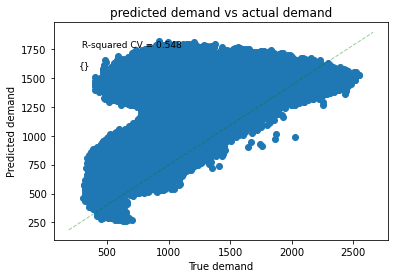

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   321.448118  
48241   342.154898  
48242   362.861679  
48243   385.357568  
48244   407.853457

In [31]:
model(pipe_ols, param_ols, X_train, y_train, X, y)

- XGBoost

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7; total time=   0.7s
[CV] END clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7; total time=   0.7s
[CV] END clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7; total time=   0.7s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.67986      0.027707         0.013939        0.000262   

  param_clf__colsample_bytree param_clf__gamma param_clf__max_depth  \
0                           1             0.01                    5   

  param_clf__min_child_weight param_clf__subsample  \
0                           6                  0.7   

                                              params  split0_test_score  \
0  {'clf__colsample_bytree': 1, 'clf__gamma': 0.0...           0.9

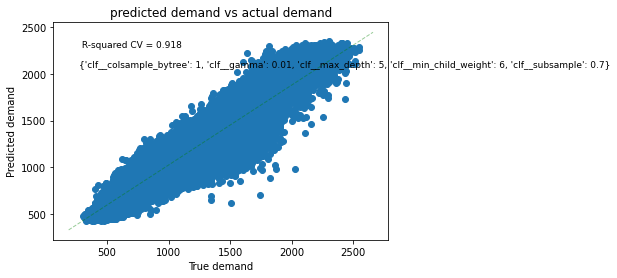

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   519.520508  
48241   514.543762  
48242   494.167511  
48243   485.215851  
48244   482.247131

In [34]:
model(pipe_xgb, param_xgb, X_train, y_train, X, y)

- KNN

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................clf__n_neighbors=5; total time=   0.1s
[CV] END .................................clf__n_neighbors=5; total time=   0.1s
[CV] END .................................clf__n_neighbors=5; total time=   0.1s
[CV] END ................................clf__n_neighbors=10; total time=   0.1s
[CV] END ................................clf__n_neighbors=10; total time=   0.1s
[CV] END ................................clf__n_neighbors=10; total time=   0.1s
[CV] END ................................clf__n_neighbors=15; total time=   0.1s
[CV] END ................................clf__n_neighbors=15; total time=   0.1s
[CV] END ................................clf__n_neighbors=15; total time=   0.1s
[CV] END ................................clf__n_neighbors=25; total time=   0.1s
[CV] END ................................clf__n_neighbors=25; total time=   0.1s
[CV] END ................................clf__n_n

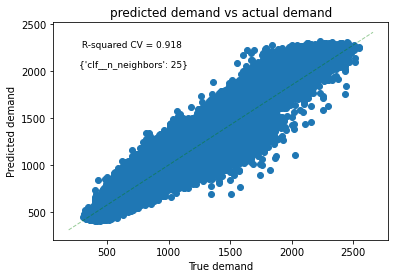

       period  temperature  hours before sunrise  hours before sunset   demand
48240   48241         11.9              3.833333            20.316667   521.12
48241   48242         12.0              3.333333            19.816667   520.36
48242   48243         12.1              2.833333            19.316667   486.52
48243   48244         12.0              2.333333            18.816667   476.52
48244   48245         11.9              1.833333            18.316667   467.12
...       ...          ...                   ...                  ...      ...
52555   52556         12.4            -15.516667            -3.800000  1156.68
52556   52557         12.3            -16.016667            -4.300000  1043.80
52557   52558         12.2            -16.516667            -4.800000   852.52
52558   52559         11.9            -17.016667            -5.300000   647.44
52559   52560         11.9            -17.516667            -5.800000   601.20

[4320 rows x 5 columns]


In [35]:
model(pipe_knn, param_knn, X_train, y_train, X, y)

- Lasso

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................cl

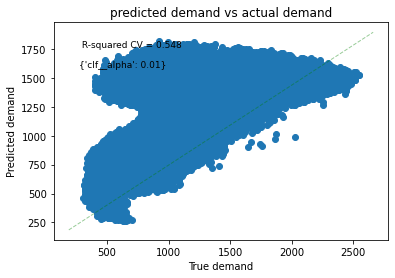

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   321.529640  
48241   342.236281  
48242   362.942921  
48243   385.439631  
48244   407.936342

In [36]:
model(pipe_lasso, param_lasso, X_train, y_train, X, y)

- Ridge

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................cl

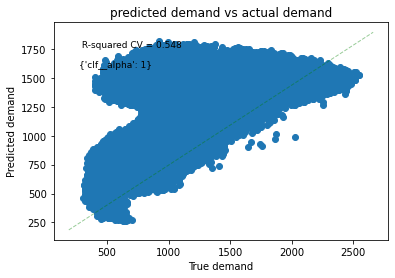

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   321.530001  
48241   342.236262  
48242   362.942523  
48243   385.439027  
48244   407.935532

In [37]:
model(pipe_ridge, param_ridge, X_train, y_train, X, y)

- Polynomial Regression

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...............................polynomial__degree=2; total time=   0.0s
[CV] END ...............................polynomial__degree=2; total time=   0.0s
[CV] END ...............................polynomial__degree=2; total time=   0.0s
[CV] END ...............................polynomial__degree=4; total time=   0.0s
[CV] END ...............................polynomial__degree=4; total time=   0.1s
[CV] END ...............................polynomial__degree=4; total time=   0.1s
[CV] END ...............................polynomial__degree=6; total time=   0.1s
[CV] END ...............................polynomial__degree=6; total time=   0.1s
[CV] END ...............................polynomial__degree=6; total time=   0.1s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.017192      0.002551         0.003838        0.000559   
1       0.042403      0.001487         0.009976        0.002202 

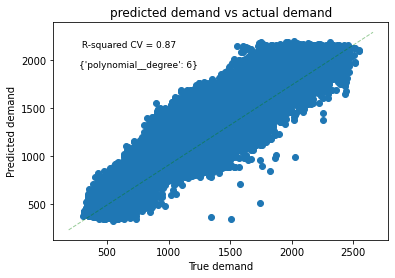

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   652.132858  
48241   516.068748  
48242   436.678987  
48243   399.641621  
48244   395.362234

In [38]:
model(pipe_poly, param_poly, X_train, y_train, X, y)

- Decision Tree Regression

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..........clf__max_depth=2, clf__min_samples_leaf=5; total time=   0.0s
[CV] END ..........clf__max_depth=2, clf__min_samples_leaf=5; total time=   0.0s
[CV] END ..........clf__max_depth=2, clf__min_samples_leaf=5; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=10; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=10; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=10; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=50; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=50; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=50; total time=   0.0s
[CV] END ........clf__max_depth=2, clf__min_samples_leaf=100; total time=   0.0s
[CV] END ........clf__max_depth=2, clf__min_samples_leaf=100; total time=   0.0s
[CV] END ........clf__max_depth=2, clf__min_samp

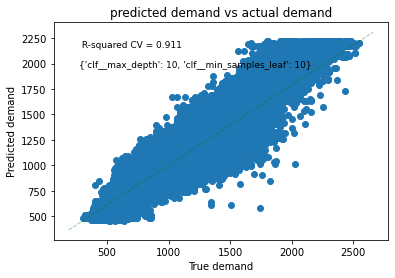

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   519.180905  
48241   519.180905  
48242   482.859227  
48243   482.859227  
48244   482.859227

In [39]:
model(pipe_tree, param_tree, X_train, y_train, X, y)

- Random Forest

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=10; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=10; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=10; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=20; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=20; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=20; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=50; total time=   0.2s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=50; total time=   0.2s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=50; total time=   0.2s
[CV] END clf__max_depth=1, clf__max_features=1, clf__n_estimators=10; total time=   0.0s
[CV] END clf__max_dept

##### CV Results
mean_score 0.8812342581497843
Model does not support model coefficients
Feature importances:  [('temperature', 0.0719854088877638), ('hours before sunrise', 0.3693710252629837), ('hours before sunset', 0.5586435658492525)]


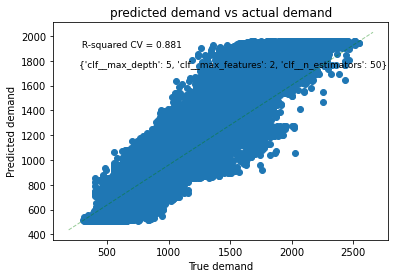

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   509.518789  
48241   509.518789  
48242   509.518789  
48243   509.518789  
48244   509.518789

In [40]:
model(pipe_forest, param_forest, X_train, y_train, X, y)

- Multi-layer Perceptron (MLP) Regression

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.8s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.7s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(

[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.7s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.7s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.5s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   1.9s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   1.9s
[CV] EN

[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.8s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.8s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   3.1s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   4.1s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   3.3s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   3.4s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invsca

[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   3.4s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   3.0s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   1.5s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   3.4s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   3.1s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   3.1s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solv

##### CV Results
mean_score 0.896091361698575
Model does not support model coefficients
Model does not support feature importances


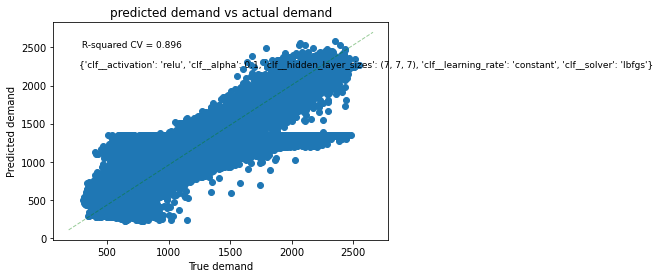

       period  temperature  hours before sunrise  hours before sunset  \
48240   48241         11.9              3.833333            20.316667   
48241   48242         12.0              3.333333            19.816667   
48242   48243         12.1              2.833333            19.316667   
48243   48244         12.0              2.333333            18.816667   
48244   48245         11.9              1.833333            18.316667   
...       ...          ...                   ...                  ...   
52555   52556         12.4            -15.516667            -3.800000   
52556   52557         12.3            -16.016667            -4.300000   
52557   52558         12.2            -16.516667            -4.800000   
52558   52559         11.9            -17.016667            -5.300000   
52559   52560         11.9            -17.516667            -5.800000   

            demand  
48240   500.666712  
48241   465.732274  
48242   462.339665  
48243   462.339665  
48244   462.339665

In [41]:
model(pipe_neural, param_neural, X_train, y_train, X, y)

## Conclusion

**KNN fits the best**

**1. KNN**                            							
  * Parameters: clf__n_neighbors: 25
  * Score: 0.918
  
**2. Decision Tree Regression**		                                        				
  * Parameters: clf__max_depth: 10, clf__min_samples_leaf: 10
  * Score: 0.911

**3. Polynomial Regression**                                    				
  * Parameters: polynomial__degree: 6
  * Score: 0.87

**4. Random Forest**                                        	 					
  * Parameters: clf__max_depth: 5, clf__max_features: 2, clf__n_estimators: 50
  * Score: 0.883

**5. Linear Regression**											                                            
  * Parameters: non
  * Score: 0.548
  
**6. Lasso** 				     					
  * Parameters: clf__alpha: 0.01
  * Score: 0.548
  
**7. Ridge**                                   							
  * Parameters: clf__alpha: 1
  * Score: 0.548

**8. XGBoost**        									                                   
  * Parameters: clf_colsample_bytree: 1, clf_gamma: 0.01, clf_ max_depth: 5, clf_min_child_weight': 6, clf_subsample: 0.7
  * Score: 0.918
  
**9. Multi-layer Perceptron (MLP) Regression**                                        	 					
  * Parameters: 'clf__activation': 'relu', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (7, 7, 7), 'clf__learning_rate': 'constant', 'clf__solver': 'lbfgs'
  * Score: 0.862